<a href="https://colab.research.google.com/github/abdulrahman-hassanin/Road-Semantic-Segmentation/blob/master/road_segmentaion_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prepration

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
%cd /root
!mkdir .kaggle
!mv /content/kaggle.json /root/.kaggle
%cd /root/.kaggle
!ls 

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

In [ ]:
!mkdir dataset
%cd /root/.kaggle/dataset

In [ ]:
!kaggle datasets download -d sumanyughoshal/kitti-road-dataset

In [ ]:
%cd /root/.kaggle/dataset/
!ls

In [ ]:
!mkdir /content/kitti-road-dataset
!cp kitti-road-dataset.zip /content/kitti-road-dataset/
!unzip /content/kitti-road-dataset/kitti-road-dataset.zip -d /content/kitti-road-dataset/

In [ ]:
%cd /content/
!ls

# Data Prepocessing

In [9]:
import numpy as np
import cv2
import os
from glob import glob
import re
import matplotlib.pyplot as plt

In [10]:
def read_data(data_folder, h, w):
  image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
  label_paths = {
                  re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
                  for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}

  images = []
  gt_images = []
  background_color = np.array([255, 0, 0])

  for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (w, h))

    gt_image_path = label_paths[os.path.basename(image_paths[i])]
    gt_image  = cv2.imread(gt_image_path)
    gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)
    gt_image = cv2.resize(gt_image, (w, h))
    gt_bg = np.all(gt_image == background_color, axis=2)
    gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
    gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

    images.append(img) 
    gt_images.append(gt_image)

  images = np.asarray(images)
  gt_images = np.asarray(gt_images)
  return images, gt_images

def read_test(data_path, h, w):
  image_paths = glob(os.path.join(data_path, 'image_2', '*.png'))
  images = []
  for i in range(len(image_paths)):
    img = cv2.imread(image_paths[i])
    img = cv2.resize(img, (w, h))
    images.append(img)

  return np.asarray(images)

In [55]:
# IMG_size = (160, 576)
# IMG_size = (160, 160)
height = 160
width = 576
data_path = 'kitti-road-dataset/data_road/training'
test_path = 'kitti-road-dataset/data_road/testing'
image, mask = read_data(data_path, height, width)
x_test = read_test(test_path, height, width)

In [12]:
image.shape, mask.shape, x_test.shape

((289, 160, 576, 3), (289, 160, 576, 2), (290, 160, 576, 3))

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(image, mask, test_size = 0.2)

# Model

In [18]:
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

In [15]:
def Unet(input_shape):
  input = Input(input_shape)

  # Encoder
  conv1 = Conv2D(64, (3, 3), padding = 'same', activation='relu') (input)
  conv1 = Conv2D(64, (3, 3), padding = 'same', activation='relu') (conv1)
  p1 = MaxPooling2D((2,2)) (conv1)
  
  conv2 = Conv2D(128, (3, 3), padding = 'same', activation='relu') (p1)
  conv2 = Conv2D(128, (3, 3), padding = 'same', activation='relu') (conv2)
  p2 = MaxPooling2D((2, 2)) (conv2)
  
  conv3 = Conv2D(256, (3, 3), padding = 'same', activation='relu') (p2)
  conv3 = Conv2D(256, (3, 3), padding = 'same', activation='relu') (conv3)
  p3 = MaxPooling2D((2, 2)) (conv3)
  
  conv4 = Conv2D(512, (3, 3), padding = 'same', activation='relu') (p3)
  conv4 = Conv2D(512, (3, 3), padding = 'same', activation='relu') (conv4)
  p4 = MaxPooling2D((2, 2)) (conv4)
  
  conv5 = Conv2D(1024, (3, 3), padding = 'same', activation='relu') (p4)
  conv5 = Conv2D(1024, (3, 3), padding = 'same', activation='relu') (conv5)

  # Decoder
  up6 = Conv2DTranspose(512, (2,2), strides=(2, 2), padding='same') (conv5)
  up6 = concatenate([up6, conv4])
  conv6 = Conv2D(512, (3, 3), padding='same', activation='relu') (up6)
  conv6 = Conv2D(512, (3, 3), padding='same', activation='relu') (conv6)
  
  up7 = Conv2DTranspose(256, (2,2), strides=(2, 2), padding='same') (conv6)
  up7 = concatenate([up7, conv3])
  conv7 = Conv2D(256, (3, 3), padding='same', activation='relu') (up7)
  conv7 = Conv2D(256, (3, 3), padding='same', activation='relu') (conv7)
  
  up8 = Conv2DTranspose(128, (2,2), strides=(2, 2), padding='same') (conv7)
  up8 = concatenate([up8, conv2])
  conv8 = Conv2D(128, (3, 3), padding='same', activation='relu') (up8)
  conv8 = Conv2D(128, (3, 3), padding='same', activation='relu') (conv8)
  
  up9 = Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same') (conv8)
  up9 = concatenate([up9, conv1])
  conv9 = Conv2D(64, (3, 3), padding='same', activation='relu') (up9)
  conv9 = Conv2D(64, (3, 3), padding='same', activation='relu') (conv9)

  output = Conv2D(2, (1, 1), padding='same', activation='sigmoid') (conv9)

  model = Model(inputs=[input], outputs=[output])

  return model

In [19]:
model = Unet((height, width, 3))

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

early = EarlyStopping(
        monitor='val_acc', 
        patience=15,
        mode='max',
        restore_best_weights=True)
check_point = ModelCheckpoint("./my_model.h5", monitor="val_loss", save_best_only=True)

callbacks_list = [ check_point, early]

history = model.fit(
    x_train, y_train,
    batch_size = 32,
    epochs = 50,
    validation_data=(x_val, y_val),
    callbacks=callbacks_list
)

Epoch 1/50
8/8 [==============================] - 23s 3s/step - loss: 1.6135 - acc: 0.7295 - val_loss: 5.2490 - val_acc: 0.7917
Epoch 2/50
8/8 [==============================] - 16s 2s/step - loss: 1.0718 - acc: 0.8104 - val_loss: 0.4648 - val_acc: 0.7917
Epoch 3/50
8/8 [==============================] - 16s 2s/step - loss: 0.4232 - acc: 0.8111 - val_loss: 0.3928 - val_acc: 0.7916
Epoch 4/50
8/8 [==============================] - 16s 2s/step - loss: 0.3730 - acc: 0.8132 - val_loss: 0.3580 - val_acc: 0.8008
Epoch 5/50
8/8 [==============================] - 15s 2s/step - loss: 0.3896 - acc: 0.8117 - val_loss: 0.3794 - val_acc: 0.8263
Epoch 6/50
8/8 [==============================] - 15s 2s/step - loss: 0.3596 - acc: 0.8220 - val_loss: 0.3603 - val_acc: 0.7950
Epoch 7/50
8/8 [==============================] - 16s 2s/step - loss: 0.3422 - acc: 0.8125 - val_loss: 0.3272 - val_acc: 0.7960
Epoch 8/50
8/8 [==============================] - 16s 2s/step - loss: 0.2959 - acc: 0.8354 - val_loss: 0

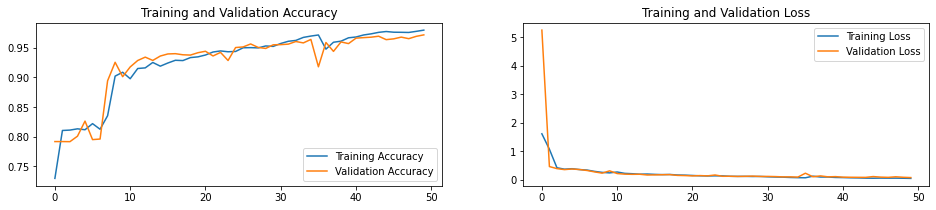

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('accuracy_loss_graph.jpg')
plt.show()

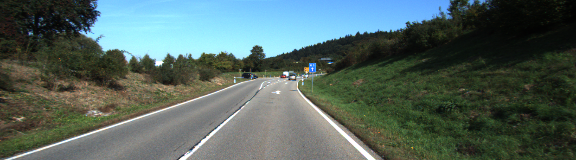

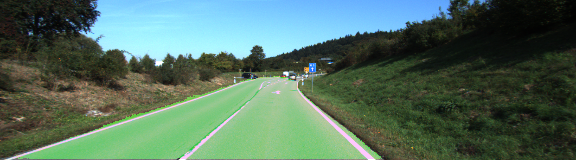

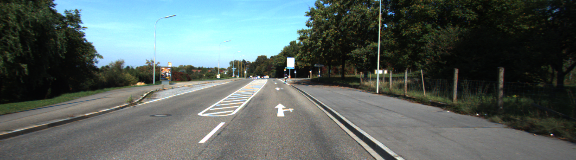

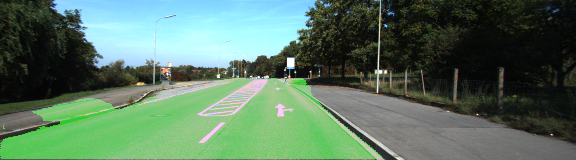

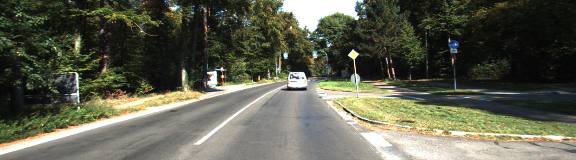

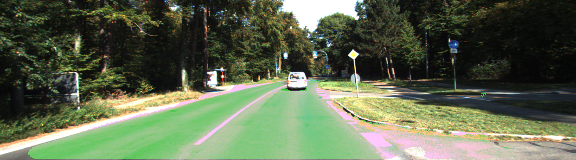

In [56]:
!mkdir /content/test-result

for t in range(3):
  img = x_test[t]
  cv2_imshow(img)
  cv2.imwrite('/content/test-result/image{}.jpg'.format(t),img)

  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  pred = [pred > 0.5]
  pred = np.asarray(pred)

  pred = np.reshape(pred, (height, width, 2))
  img = np.reshape(img, (height, width, 3))

  for i in range(height):
    for j in range(width):
      if(pred[i, j, 0] == 0):
        img[i, j, 1] = 200

  cv2_imshow(img)
  cv2.imwrite('/content/test-result/image{}_result.jpg'.format(t),img)